In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"

JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [3]:
import jaxley as jx
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

In [4]:
import dendrotweaks as dd
dd.__version__

--No graphics will be displayed.


'0.5.1'

In [5]:
from dendrotweaks.biophys.io import MODFileConverter

In [6]:
import glob

In [7]:
# park_mod_dir = os.path.join("examples", "Park_2019", "biophys", "mod")
# template = os.path.join("examples", "Templates", "jaxley.py")

# out_dir = os.path.join("examples", "Park_2019", "biophys", "python")
# os.makedirs(out_dir, exist_ok=True)

# converter = MODFileConverter()

# converted, failed = [], []

# for mod_path in sorted(glob.glob(os.path.join(park_mod_dir, "*.mod"))):
#     txt = open(mod_path, "r", encoding="utf-8", errors="ignore").read()

#     base = os.path.splitext(os.path.basename(mod_path))[0] 
#     out_py = os.path.join(out_dir, f"{base}jx.py") 

#     try:
#         converter.convert(mod_path, out_py, template)
#         converted.append((mod_path, out_py))
#     except Exception as e:
#         failed.append((mod_path, repr(e)))

# print(f"Converted: {len(converted)} | Failed: {len(failed)}")
# if failed:
#     print("First few failures:")
#     for p, err in failed[:5]:
#         print("  ", p, "->", err)

In [8]:
# from pathlib import Path

# p = Path("examples/Park_2019/biophys/python/CaHVAjx.py")
# s = p.read_text()

# s2 = s.replace("compute_kinetic_variables(vm)", "compute_kinetic_variables(v)")
# if s2 == s:
#     raise ValueError("Did not find the exact string. Open the file and patch the line manually.")

# p.write_text(s2)
# print("Patched CaHVAjx.py: vm -> v in compute_current() call")

In [9]:
from examples.Park_2019.biophys.python.Najx import Na
from examples.Park_2019.biophys.python.Kvjx import Kv
from examples.Park_2019.biophys.python.Kmjx import Km
from examples.Park_2019.biophys.python.KCajx import KCa
from examples.Park_2019.biophys.python.Kajx import Ka
from examples.Park_2019.biophys.python.CaLVAjx import CaLVA
from examples.Park_2019.biophys.python.CaHVAjx import CaHVA
from jaxley.channels import Leak

5 MultiCompartment Model 

In [10]:
soma_branch = jx.Branch([jx.Compartment()]) # 1 comp
basal_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps
apic_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps

cell = jx.Cell([soma_branch, basal_branch, apic_branch], parents=[-1, 0, 0])


In [11]:
temperature = 37.0

na = Na()
kv = Kv()
km = Km()
ka = Ka()
cahva = CaHVA()
calva = CaLVA()
kca   = KCa()

for ch in [na, kv, km, ka, cahva, calva, kca]:
    if hasattr(ch, "set_tadj"):
        try: ch.set_tadj(temperature)
        except: pass
    ch.temperature = temperature



cell.insert(Leak())
cell.insert(na); cell.insert(kv); cell.insert(km); cell.insert(ka)
cell.insert(cahva); cell.insert(calva)
cell.insert(kca) 



(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2684)
(base.py, line 2684)
(base.py, line 2660)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2684)
(base.py, line 2684)


In [12]:
v_init = -79.0
Rm = 11000.0
Ri = 100.0
Cm = 1.0

cell.set("v", v_init)
cell.set("axial_resistivity", Ri) 
cell.branch(0).set("capacitance", Cm)  # soma: 1
cell.branch(1).set("capacitance", 2 * Cm) # dend: 2
cell.branch(2).set("capacitance", 2 * Cm) # dend: 2


In [13]:
# soma
cell.branch(0).comp(0).set("length", 20)
cell.branch(0).comp(0).set("radius", 6)

cell.branch(1).comp(0).set("length", 100.0)   # prox
cell.branch(1).comp(0).set("radius", 0.50)
cell.branch(1).comp(1).set("length", 100.0)   # dist
cell.branch(1).comp(1).set("radius", 0.50)


cell.branch(2).comp(0).set("length", 100.0)   # prox
cell.branch(2).comp(0).set("radius", 0.50)
cell.branch(2).comp(1).set("length", 100.0)   # dist
cell.branch(2).comp(1).set("radius", 0.50)

In [14]:
print("soma:")
print(cell.branch(0).nodes[["length","radius", "capacitance"]])
print("basal:")
print(cell.branch(1).nodes[["length","radius", "capacitance"]])
print("apical:")
print(cell.branch(2).nodes[["length","radius", "capacitance"]])

soma:
   length  radius  capacitance
0    20.0     6.0          1.0
basal:
   length  radius  capacitance
1   100.0     0.5          2.0
2   100.0     0.5          2.0
apical:
   length  radius  capacitance
3   100.0     0.5          2.0
4   100.0     0.5          2.0


In [15]:
cell.set("Leak_gLeak",(1.0 )/ (Rm))
cell.set("Leak_eLeak", v_init) 

In [16]:
soma = cell.branch(0)
dend = [cell.branch(1), cell.branch(2)]

scale = 0.15

soma.set("gbar_Na", 504.9 * scale)
soma.set("gbar_Kv", 50.0 * scale)
soma.set("gbar_Km", 2.794)
soma.set("gbar_Ka", 0.0054)
soma.set("gbar_KCa", 2.1)
soma.set("gbar_CaHVA", 0.05)
soma.set("gbar_CaLVA", 3e-5)

for br in dend:
    br.set("gbar_Na", 302.94 * scale)
    br.set("gbar_Kv", 1.5 * scale)
    br.set("gbar_Km", 1.27 )
    br.set("gbar_Ka", 0.108 )
    br.set("gbar_KCa", 2.1)
    br.set("gbar_CaHVA", 0.05)
    br.set("gbar_CaLVA", 3e-5)

In [17]:
print(cell.nodes[["Leak_gLeak","Leak_eLeak","gbar_Na","gbar_Kv"]])

   Leak_gLeak  Leak_eLeak  gbar_Na  gbar_Kv
0    0.000091       -79.0   75.735    7.500
1    0.000091       -79.0   45.441    0.225
2    0.000091       -79.0   45.441    0.225
3    0.000091       -79.0   45.441    0.225
4    0.000091       -79.0   45.441    0.225


In [31]:
dt = 0.025
t_max = 200.0
I = jx.step_current(i_delay=100.0, i_dur=50.0, i_amp=2, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I)
cell.branch(0).comp(0).record("v")
cell.branch(0).comp(0).record("CaCon_i")   # dend distal calcium

out = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


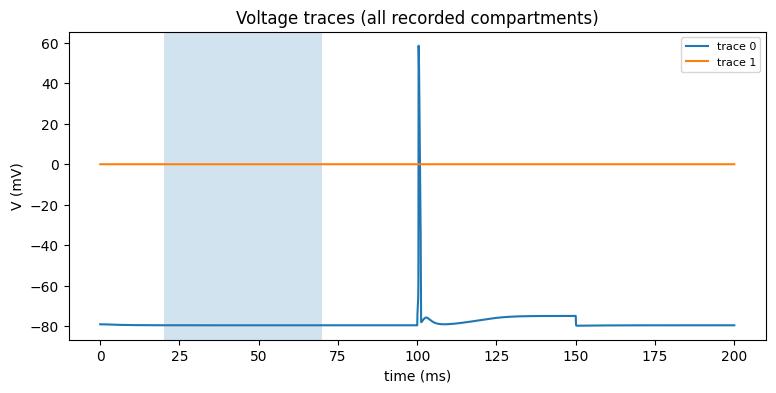

In [32]:
out_arr = np.array(out)      
T = out_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(out_arr.shape[0]):
    plt.plot(t, out_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [18]:
dt = 0.025
t_max = 200.0
I0 = jx.step_current(i_delay=0.0, i_dur=0.0, i_amp=0.0, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I0) 
cell.branch(0).comp(0).record("v")
v = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


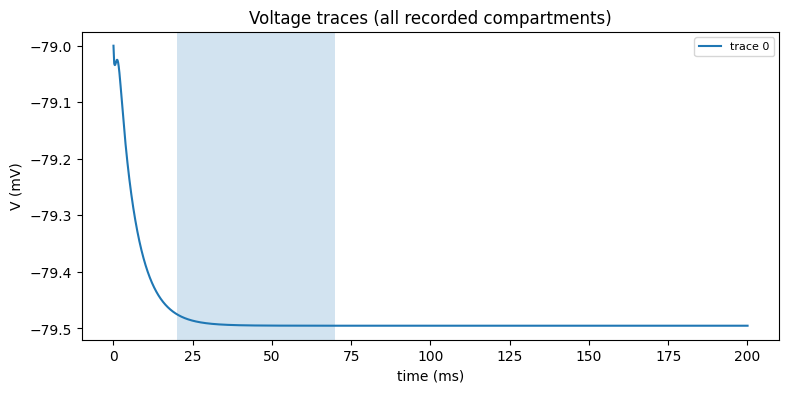

In [19]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [20]:
dt = 0.025
t_max = 200.0
I0_all = jx.step_current(i_delay=0.0, i_dur=0.0, i_amp=0.0, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I0_all)      # soma-only
cell.record("v")

v = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 5 recordings. See `.recordings` for details.


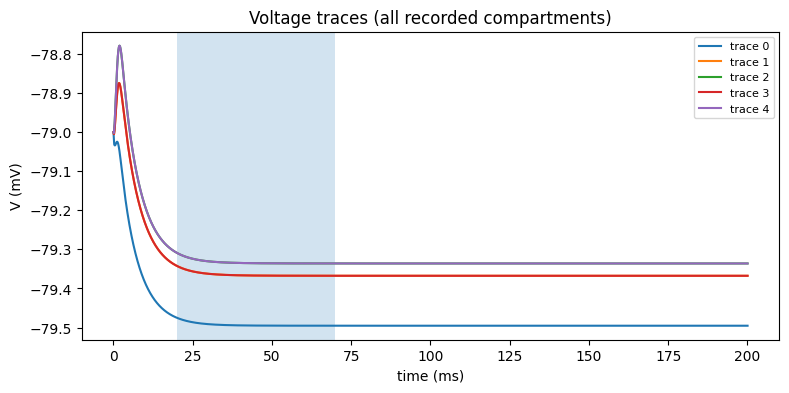

In [21]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [22]:
dt = 0.025
t_max = 200.0
I = jx.step_current(i_delay=50.0, i_dur=100.0, i_amp=0.2, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I)      # soma-only
cell.record("v")

v = jx.integrate(cell, delta_t=dt)

Added 1 external_states. See `.externals` for details.
Added 5 recordings. See `.recordings` for details.


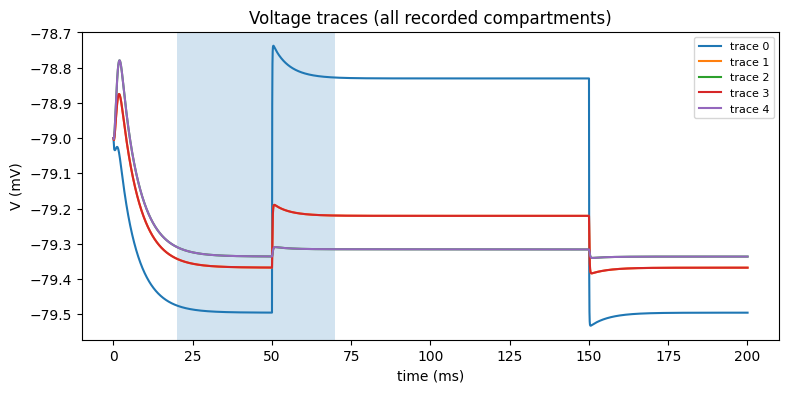

In [23]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

In [24]:
print(np.array(cell.externals["i"]).shape, np.array(cell.externals["i"]).max())

(1, 8001) 0.2


In [25]:
print("Leak_gLeak:", cell.nodes["Leak_gLeak"].iloc[0])

Leak_gLeak: 9.09090909090909e-05


In [26]:
print(cell.nodes[["Leak_gLeak","Leak_eLeak","gbar_Na","gbar_Kv"]])

   Leak_gLeak  Leak_eLeak  gbar_Na  gbar_Kv
0    0.000091       -79.0   75.735    7.500
1    0.000091       -79.0   45.441    0.225
2    0.000091       -79.0   45.441    0.225
3    0.000091       -79.0   45.441    0.225
4    0.000091       -79.0   45.441    0.225


calcium checks

In [34]:
CA_CON_KEY = "CaCon_i"         # replace with what you discovered
CA_CUR_KEY  = "i_ca"           # replace with what you discovered (could be i_Ca)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


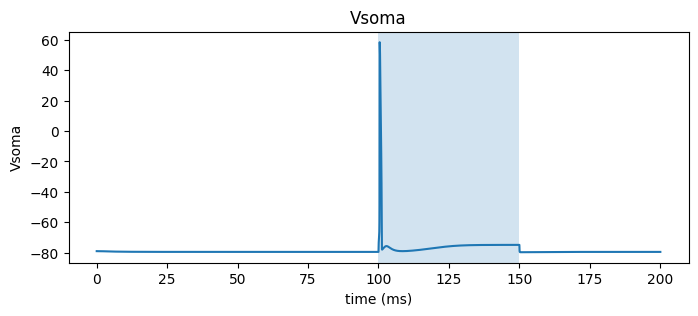

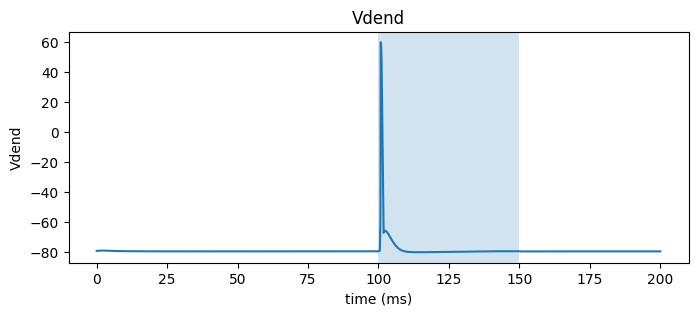

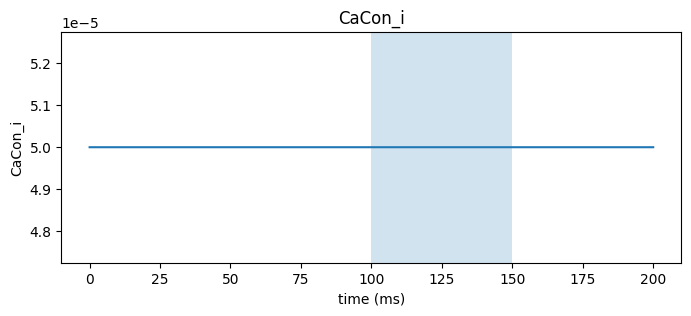

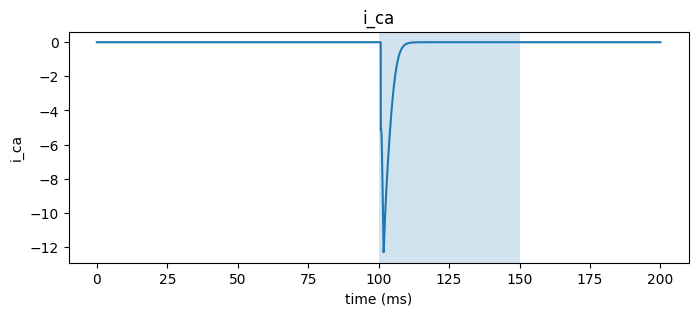

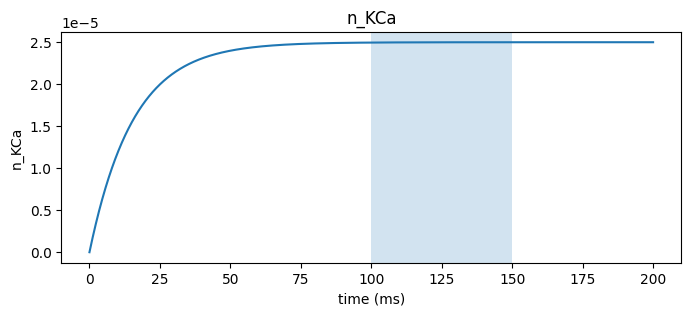

In [36]:


dt = 0.025
t_max = 200.0
I = jx.step_current(i_delay=100.0, i_dur=50.0, i_amp=2, delta_t=dt, t_max=t_max)

cell.delete_stimuli()
cell.delete_recordings()

# stimulate soma only
cell.branch(0).comp(0).stimulate(I)

# record soma voltage, dend voltage, calcium concentration, calcium current, and KCa gate
cell.branch(0).comp(0).record("v")
cell.branch(1).comp(1).record("v")

cell.branch(1).comp(1).record(CA_CON_KEY)
cell.branch(1).comp(1).record(CA_CUR_KEY)
cell.branch(1).comp(1).record("n_KCa")

out = jx.integrate(cell, delta_t=dt)

out_arr = np.array(out)  # usually (#recordings, T) or similar
T = out_arr.shape[-1]
t = np.arange(T) * dt

# Plot 5 separate figures (one per trace)
labels = ["Vsoma", "Vdend", CA_CON_KEY, CA_CUR_KEY, "n_KCa"]
for i, lab in enumerate(labels):
    plt.figure(figsize=(8,3))
    plt.plot(t, out_arr[i])
    plt.axvspan(100.0, 150.0, alpha=0.2)
    plt.xlabel("time (ms)")
    plt.ylabel(lab)
    plt.title(lab)
    plt.show()